In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd  drive/MyDrive/Colab Notebooks/'Deepfake Asnmnt'/

/content/drive/MyDrive/Colab Notebooks/Deepfake Asnmnt


In [3]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.7 MB/s eta 0:00:00


In [4]:
import timm 
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
class BaseDataset(Dataset):
    def __init__(self, data_path):
        self.data_path = data_path

        # normalize
        self.transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.imgs = []
        self.labels = []
        
        # parsing and getting labels
        for file in os.listdir(data_path):
            if file.endswith('.png'):
                img_path = os.path.join(data_path, file)
                label = file.split('_')[0]
                self.imgs.append(img_path)
                self.labels.append(label)
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = Image.open(self.imgs[idx])
        img = self.transforms(img)
        label = 1 if self.labels[idx] == 'fake' else 0
        return img, label

In [7]:
# Experiment Class
class Experiment:
    def __init__(self, title):
        self.num_classes = 2
        self.title = title
        self.xc_model = timm.create_model('xception', pretrained = True, num_classes = self.num_classes).to(device)
        self.ef_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes = self.num_classes).to(device)

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer_xc = optim.Adam(self.xc_model.parameters(), lr=0.001, weight_decay = 0.001)
        self.optimizer_ef = optim.Adam(self.ef_model.parameters(), lr=0.001, weight_decay = 0.001)


    def train_model(self, trainloader, valloader):
        num_epochs = 100

        xc_train_accs = []
        xc_val_accs = []
        ef_train_accs = []
        ef_val_accs = []

        for epoch in range(num_epochs):
            # Training loop for Xception model
            self.xc_model.train()
            xc_total_loss = 0
            xc_total_correct = 0
            for images, labels in trainloader:
                images = images.to(device)
                labels = labels.to(device)
                self.optimizer_xc.zero_grad()
                outputs = self.xc_model(images)
                labels_onehot = F.one_hot(labels, num_classes = self.num_classes).float()
                loss = self.criterion(outputs, labels_onehot)
                loss.backward()
                self.optimizer_xc.step()

                xc_total_loss += loss.item()
                xc_total_correct += (outputs.argmax(dim=1) == labels).sum().item()

            xc_train_loss = xc_total_loss / len(trainloader)
            xc_train_acc = xc_total_correct / len(trainloader.dataset)
            xc_train_accs.append(xc_train_acc)

            print(f'Epoch {epoch+1} - Xception model - Training loss: {xc_train_loss:.4f} - Training accuracy: {xc_train_acc:.4f}')

            # Training loop for EfficientNet model
            self.ef_model.train()
            ef_total_loss = 0
            ef_total_correct = 0
            for images, labels in trainloader:
                images = images.to(device)
                labels = labels.to(device)
                self.optimizer_ef.zero_grad()
                outputs = self.ef_model(images)
                labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float()
                loss = self.criterion(outputs, labels_onehot)
                loss.backward()
                self.optimizer_ef.step()

                ef_total_loss += loss.item()
                ef_total_correct += (outputs.argmax(dim=1) == labels).sum().item()

            ef_train_loss = ef_total_loss / len(trainloader)
            ef_train_acc = ef_total_correct / len(trainloader.dataset)
            ef_train_accs.append(ef_train_acc)

            print(f'Epoch {epoch+1} - EfficientNet model - Training loss: {ef_train_loss:.4f} - Training accuracy: {ef_train_acc:.4f}')


            # Validation loop
            self.xc_model.eval()
            self.ef_model.eval()
            with torch.no_grad():
                xc_total, xc_correct = 0, 0
                for images, labels in valloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.xc_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    xc_total += labels.size(0)
                    xc_correct += (predicted == labels).sum().item()
                xc_accuracy = xc_correct / xc_total
                xc_val_accs.append(xc_accuracy)
            
                print(f'Epoch {epoch+1} - Xception model - Validation accuracy: {xc_accuracy:.4f}')

                ef_total, ef_correct = 0, 0
                for images, labels in valloader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.ef_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    ef_total += labels.size(0)
                    ef_correct += (predicted == labels).sum().item()
                ef_accuracy = ef_correct / ef_total
                ef_val_accs.append(ef_accuracy)

                print(f'Epoch {epoch+1} - EfficientNet model - Validation accuracy: {ef_accuracy:.4f}')

        plt.plot(xc_train_accs, label='Xception Training Accuracy')
        plt.plot(xc_val_accs, label='Xception Validation Accuracy')
        plt.plot(ef_train_accs, label='EfficientNet Training Accuracy')
        plt.plot(ef_val_accs, label='EfficientNet Validation Accuracy')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(self.title)
        plt.show()
        plt.savefig(f'{self.title} Train, Validation Accuracy.png')

    def test_model(self, testloader):

        self.xc_model.eval()
        self.ef_model.eval()
        with torch.no_grad():
            xc_total, xc_correct = 0, 0
            xc_true_labels, xc_predicted_labels = [], []
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.xc_model(images)
                _, predicted = torch.max(outputs.data, 1)
                xc_total += labels.size(0)
                xc_correct += (predicted == labels).sum().item()
                xc_true_labels += labels.cpu().tolist()
                xc_predicted_labels += predicted.cpu().tolist()
            xc_accuracy = xc_correct / xc_total
            xc_precision, xc_recall, xc_f1, _ = precision_recall_fscore_support(xc_true_labels, xc_predicted_labels, average='binary')
        
            print(f'Xception model - Test accuracy: {xc_accuracy:.4f}')
            print(f'Xception model - Test precision: {xc_precision:.4f}')
            print(f'Xception model - Test recall: {xc_recall:.4f}')
            print(f'Xception model - Test F1 score: {xc_f1:.4f}')


            ef_total, ef_correct = 0, 0
            ef_true_labels, ef_predicted_labels = [], []
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.ef_model(images)
                _, predicted = torch.max(outputs.data, 1)
                ef_total += labels.size(0)
                ef_correct += (predicted == labels).sum().item()
                ef_true_labels += labels.cpu().tolist()
                ef_predicted_labels += predicted.cpu().tolist()
            ef_accuracy = ef_correct / ef_total
            ef_precision, ef_recall, ef_f1, _ = precision_recall_fscore_support(ef_true_labels, ef_predicted_labels, average='binary')

            print(f'EfficientNet model - Test accuracy: {ef_accuracy:.4f}')
            print(f'EfficientNet model - Test precision: {ef_precision:.4f}')
            print(f'EfficientNet model - Test recall: {ef_recall:.4f}')
            print(f'EfficientNet model - Test F1 score: {ef_f1:.4f}')

            # create histogram
            xc_metrics = [xc_accuracy, xc_precision, xc_recall, xc_f1]
            ef_metrics = [ef_accuracy, ef_precision, ef_recall, ef_f1]

            metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

            bar_width = 0.35
            plt.bar(np.arange(len(metric_names)), xc_metrics, label='Xception', color='blue', width=bar_width)
            plt.bar(np.arange(len(metric_names)) + bar_width, ef_metrics, label='EfficientNet', color='green', width=bar_width)

            plt.xlabel('Metric')
            plt.ylabel('Value')
            plt.title(self.title)
            plt.xticks(np.arange(len(metric_names)) + bar_width/2, metric_names)
            plt.legend()
            plt.show()
            plt.savefig(f'{self.title} Test Result.png')

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


Epoch 1 - Xception model - Training loss: 0.3137 - Training accuracy: 0.8608
Epoch 1 - EfficientNet model - Training loss: 1.0525 - Training accuracy: 0.7792
Epoch 1 - Xception model - Validation accuracy: 0.9378
Epoch 1 - EfficientNet model - Validation accuracy: 0.7736
Epoch 2 - Xception model - Training loss: 0.1114 - Training accuracy: 0.9683
Epoch 2 - EfficientNet model - Training loss: 0.1757 - Training accuracy: 0.9425
Epoch 2 - Xception model - Validation accuracy: 0.5299
Epoch 2 - EfficientNet model - Validation accuracy: 0.9527
Epoch 3 - Xception model - Training loss: 0.0986 - Training accuracy: 0.9642
Epoch 3 - EfficientNet model - Training loss: 0.0604 - Training accuracy: 0.9750
Epoch 3 - Xception model - Validation accuracy: 0.9577
Epoch 3 - EfficientNet model - Validation accuracy: 0.9751
Epoch 4 - Xception model - Training loss: 0.0427 - Training accuracy: 0.9858
Epoch 4 - EfficientNet model - Training loss: 0.0354 - Training accuracy: 0.9892
Epoch 4 - Xception model -

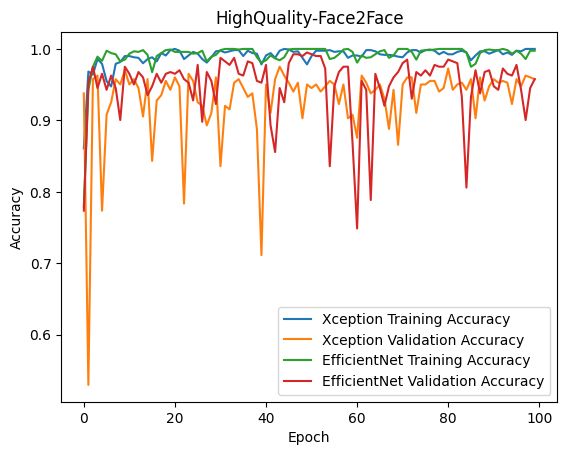

Xception model - Test accuracy: 0.9523
Xception model - Test precision: 0.9245
Xception model - Test recall: 0.9849
Xception model - Test F1 score: 0.9538
EfficientNet model - Test accuracy: 0.9472
EfficientNet model - Test precision: 0.9045
EfficientNet model - Test recall: 1.0000
EfficientNet model - Test F1 score: 0.9499


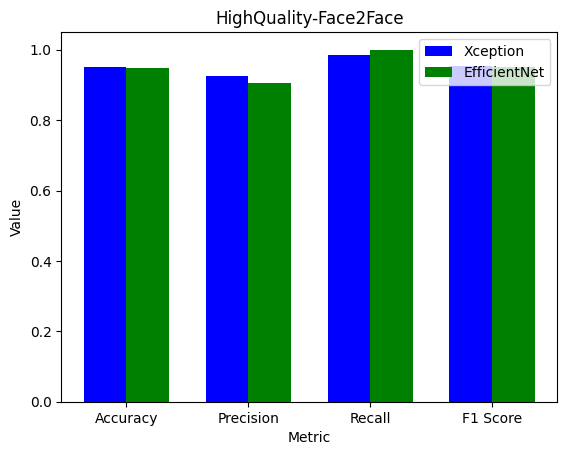

<Figure size 640x480 with 0 Axes>

In [8]:
#1) HighQuality-Face2Face

hf_train_dataset = BaseDataset(data_path = "High Quality/f2f_data/train")
hf_trainloader = DataLoader(hf_train_dataset, batch_size=32, shuffle=True)
hf_val_dataset = BaseDataset(data_path = "High Quality/f2f_data/val")
hf_valloader = DataLoader(hf_val_dataset, batch_size=32, shuffle=True)
hf_test_dataset = BaseDataset(data_path = "High Quality/f2f_data/test")
hf_testloader = DataLoader(hf_test_dataset, batch_size=32, shuffle=True)

hf = Experiment("HighQuality-Face2Face")
hf.train_model(hf_trainloader, hf_valloader)
hf.test_model(hf_testloader)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1 - Xception model - Training loss: 0.5112 - Training accuracy: 0.7433
Epoch 1 - EfficientNet model - Training loss: 1.0365 - Training accuracy: 0.7483
Epoch 1 - Xception model - Validation accuracy: 0.7811
Epoch 1 - EfficientNet model - Validation accuracy: 0.8284
Epoch 2 - Xception model - Training loss: 0.2844 - Training accuracy: 0.8967
Epoch 2 - EfficientNet model - Training loss: 0.2039 - Training accuracy: 0.9192
Epoch 2 - Xception model - Validation accuracy: 0.7562
Epoch 2 - EfficientNet model - Validation accuracy: 0.8831
Epoch 3 - Xception model - Training loss: 0.1917 - Training accuracy: 0.9308
Epoch 3 - EfficientNet model - Training loss: 0.0890 - Training accuracy: 0.9633
Epoch 3 - Xception model - Validation accuracy: 0.8134
Epoch 3 - EfficientNet model - Validation accuracy: 0.9279
Epoch 4 - Xception model - Training loss: 0.1729 - Training accuracy: 0.9400
Epoch 4 - EfficientNet model - Training loss: 0.0487 - Training accuracy: 0.9858
Epoch 4 - Xception model -

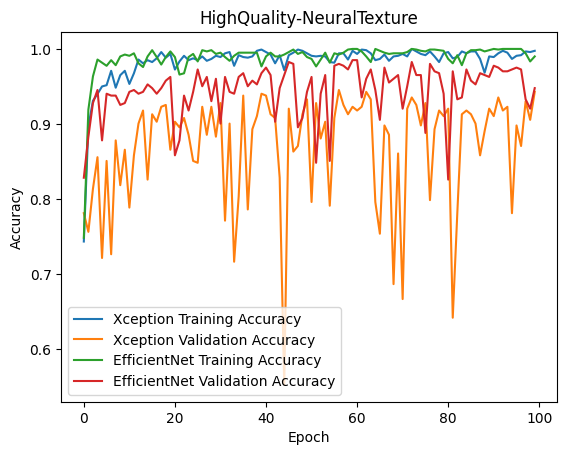

Xception model - Test accuracy: 0.9121
Xception model - Test precision: 0.9409
Xception model - Test recall: 0.8794
Xception model - Test F1 score: 0.9091
EfficientNet model - Test accuracy: 0.9673
EfficientNet model - Test precision: 0.9745
EfficientNet model - Test recall: 0.9598
EfficientNet model - Test F1 score: 0.9671


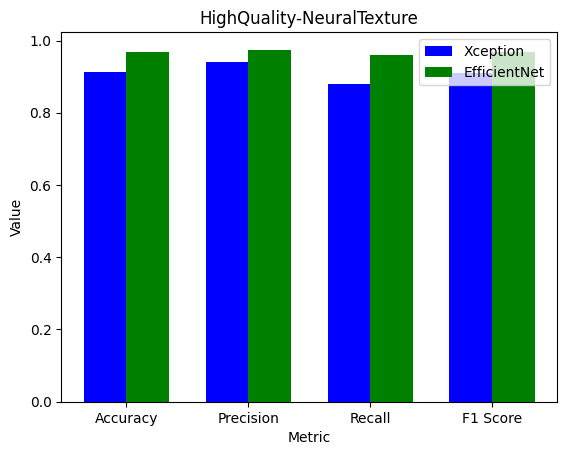

<Figure size 640x480 with 0 Axes>

In [9]:
#2) HighQuality-NeuralTexture

hn_train_dataset = BaseDataset(data_path = "High Quality/nt_data/train")
hn_trainloader = DataLoader(hn_train_dataset, batch_size=32, shuffle=True)
hn_val_dataset = BaseDataset(data_path = "High Quality/nt_data/val")
hn_valloader = DataLoader(hn_val_dataset, batch_size=32, shuffle=True)
hn_test_dataset = BaseDataset(data_path = "High Quality/nt_data/test")
hn_testloader = DataLoader(hn_test_dataset, batch_size=32, shuffle=True)

hn = Experiment("HighQuality-NeuralTexture")
hn.train_model(hn_trainloader, hn_valloader)
hn.test_model(hn_testloader)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1 - Xception model - Training loss: 0.1917 - Training accuracy: 0.9233
Epoch 1 - EfficientNet model - Training loss: 0.4898 - Training accuracy: 0.9075
Epoch 1 - Xception model - Validation accuracy: 0.9677
Epoch 1 - EfficientNet model - Validation accuracy: 0.9303
Epoch 2 - Xception model - Training loss: 0.1130 - Training accuracy: 0.9617
Epoch 2 - EfficientNet model - Training loss: 0.1229 - Training accuracy: 0.9617
Epoch 2 - Xception model - Validation accuracy: 0.7463
Epoch 2 - EfficientNet model - Validation accuracy: 0.9826
Epoch 3 - Xception model - Training loss: 0.0274 - Training accuracy: 0.9867
Epoch 3 - EfficientNet model - Training loss: 0.0424 - Training accuracy: 0.9808
Epoch 3 - Xception model - Validation accuracy: 0.9527
Epoch 3 - EfficientNet model - Validation accuracy: 0.9900
Epoch 4 - Xception model - Training loss: 0.0644 - Training accuracy: 0.9758
Epoch 4 - EfficientNet model - Training loss: 0.0141 - Training accuracy: 0.9958
Epoch 4 - Xception model -

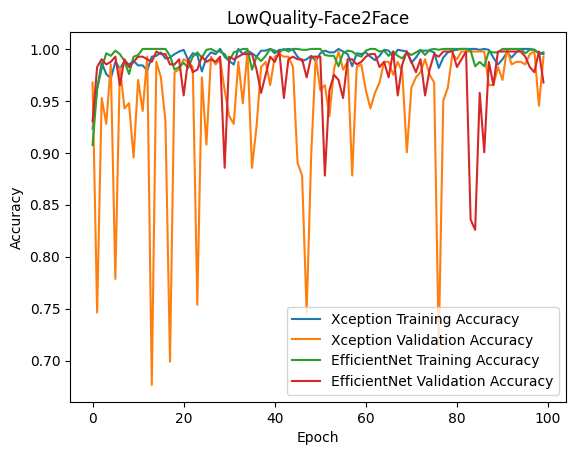

Xception model - Test accuracy: 0.9824
Xception model - Test precision: 0.9660
Xception model - Test recall: 1.0000
Xception model - Test F1 score: 0.9827
EfficientNet model - Test accuracy: 0.9523
EfficientNet model - Test precision: 1.0000
EfficientNet model - Test recall: 0.9045
EfficientNet model - Test F1 score: 0.9499


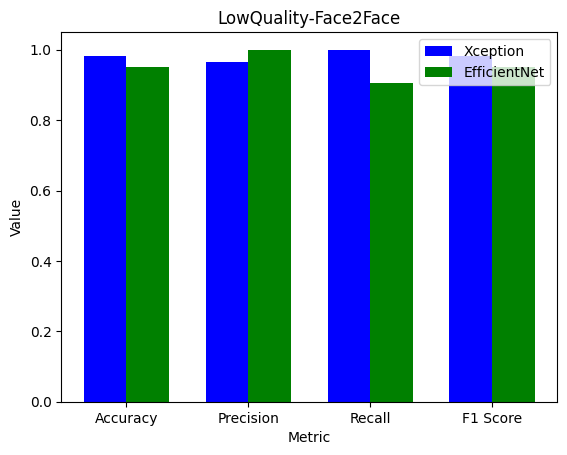

<Figure size 640x480 with 0 Axes>

In [10]:
#3) LowQuality-Face2Face

lf_train_dataset = BaseDataset(data_path = "Low Quality/f2f_data/train")
lf_trainloader = DataLoader(lf_train_dataset, batch_size=32, shuffle=True)
lf_val_dataset = BaseDataset(data_path = "Low Quality/f2f_data/val")
lf_valloader = DataLoader(lf_val_dataset, batch_size=32, shuffle=True)
lf_test_dataset = BaseDataset(data_path = "Low Quality/f2f_data/test")
lf_testloader = DataLoader(lf_test_dataset, batch_size=32, shuffle=True)

lf = Experiment("LowQuality-Face2Face")
lf.train_model(lf_trainloader, lf_valloader)
lf.test_model(lf_testloader)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


Epoch 1 - Xception model - Training loss: 0.2017 - Training accuracy: 0.9242
Epoch 1 - EfficientNet model - Training loss: 0.4843 - Training accuracy: 0.9142
Epoch 1 - Xception model - Validation accuracy: 0.9826
Epoch 1 - EfficientNet model - Validation accuracy: 0.9353
Epoch 2 - Xception model - Training loss: 0.0686 - Training accuracy: 0.9792
Epoch 2 - EfficientNet model - Training loss: 0.1518 - Training accuracy: 0.9650
Epoch 2 - Xception model - Validation accuracy: 0.9478
Epoch 2 - EfficientNet model - Validation accuracy: 0.9577
Epoch 3 - Xception model - Training loss: 0.1005 - Training accuracy: 0.9692
Epoch 3 - EfficientNet model - Training loss: 0.0383 - Training accuracy: 0.9867
Epoch 3 - Xception model - Validation accuracy: 0.9776
Epoch 3 - EfficientNet model - Validation accuracy: 0.9950
Epoch 4 - Xception model - Training loss: 0.0645 - Training accuracy: 0.9858
Epoch 4 - EfficientNet model - Training loss: 0.0553 - Training accuracy: 0.9842
Epoch 4 - Xception model -

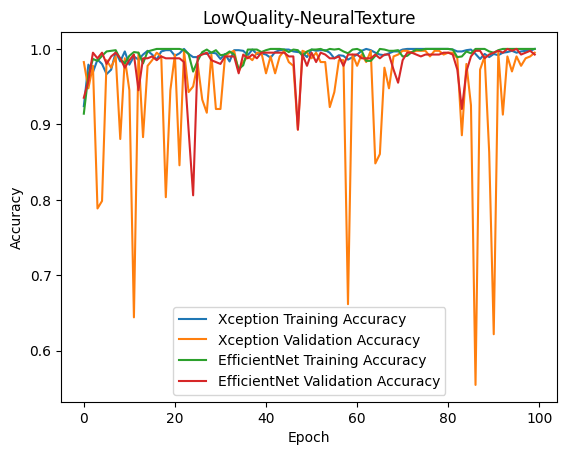

Xception model - Test accuracy: 0.9975
Xception model - Test precision: 1.0000
Xception model - Test recall: 0.9950
Xception model - Test F1 score: 0.9975
EfficientNet model - Test accuracy: 0.9975
EfficientNet model - Test precision: 1.0000
EfficientNet model - Test recall: 0.9950
EfficientNet model - Test F1 score: 0.9975


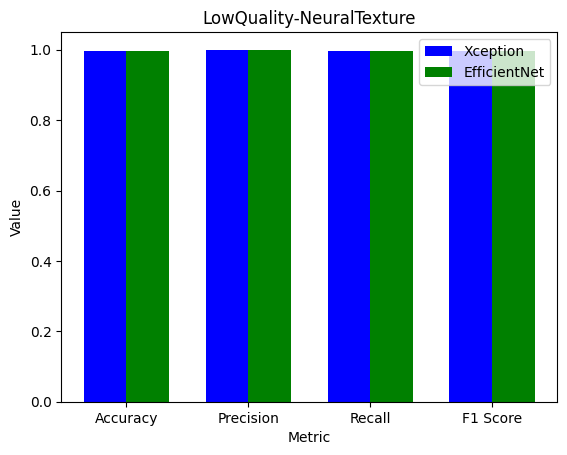

<Figure size 640x480 with 0 Axes>

In [11]:
#4) LowQuality-NeuralTexture

ln_train_dataset = BaseDataset(data_path = "Low Quality/nt_data/train")
ln_trainloader = DataLoader(ln_train_dataset, batch_size=32, shuffle=True)
ln_val_dataset = BaseDataset(data_path = "Low Quality/nt_data/val")
ln_valloader = DataLoader(ln_val_dataset, batch_size=32, shuffle=True)
ln_test_dataset = BaseDataset(data_path = "Low Quality/nt_data/test")
ln_testloader = DataLoader(ln_test_dataset, batch_size=32, shuffle=True)

ln = Experiment("LowQuality-NeuralTexture")
ln.train_model(ln_trainloader, ln_valloader)
ln.test_model(ln_testloader)